In [1]:
import sys
from jax import random
import matplotlib.pyplot as plt
sys.path.append("../")

from models.equivariant_gnn import NEQUIP 
from models.egnn import EGNN
import e3nn_jax as e3nn
from models.graph_utils import nearest_neighbors, rotate_representation

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-04-06 09:16:49.100937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/glib/2.56.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gcc/12.1.0-fasrc01/lib:/n/helmod/apps/centos7/Core/cudnn/8.5.0.96_cuda11-fasrc01/lib:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.7.1-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/mpc/1.2.1-fasrc01/lib64:/n/helmod/apps/centos7/Core/mpfr/4.1.0-fasrc01/lib64:/n/helmod/apps/centos7/Core/gmp/6.2.1-fasrc01/lib64
2023-04-06 09:16:49.101447: W tensorflow/compiler/xla/stream_executor/platform/defaul

In [2]:
import jax
import jax.numpy as np
import numpy as onp
import jax.numpy as jnp
import jraph
import flax.linen as nn

from functools import partial
import e3nn_jax as e3nn

In [3]:
n_nodes = 5000

In [4]:
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/halos.npy")[:, :n_nodes,:6]

In [5]:
#x = x.at[...,-1].set(np.log10(x[...,-1]))

In [6]:
x = (x - np.min(x, axis=0))/(np.max(x,axis=0) - np.min(x, axis=0))

In [7]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:4], 20)

In [8]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(NEQUIP(
          target_irreps=e3nn.Irreps('2x1o'),
          input_node_irreps=e3nn.Irreps('1o'),
        )
        )
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

In [9]:
graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=x[:4, :, :], 
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)
x_out = graph_out.nodes

#x_out = graph_out.nodes

angle_deg = 45.
axis = jnp.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

graph = jraph.GraphsTuple(
          n_node=np.array(4 * [[n_nodes]]), 
          n_edge=np.array(4 * [[20]]),
          nodes=jax.vmap(rotate_representation, in_axes=(0,None,None))(x[:4, :, :], angle_deg, axis),
          edges=None,
          globals=np.ones((4, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)
x_out = graph_out.nodes


ValueError: Unable to convert string "2xo" into an Irreps

In [ ]:
x_out

Array([[[ 0.27897522,  1.5665269 ,  1.0321441 , ..., -0.76227325,
         -0.5838428 ,  0.        ],
        [ 0.9546184 ,  0.8013499 ,  0.88975596, ...,  0.26463014,
         -0.5422987 ,  0.        ],
        [-0.46238297,  1.2226007 ,  1.2003314 , ..., -0.00486011,
          0.7661044 ,  0.        ],
        ...,
        [ 0.66829485,  0.49967432,  0.66091096, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.11928736,  0.5757254 ,  0.858421  , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.71536434, -0.41856158, -0.35173106, ..., -0.00994764,
          0.82833576,  0.        ]],

       [[ 0.906414  ,  0.3395133 ,  1.5557454 , ..., -0.29979503,
         -0.83357775,  0.        ],
        [-0.55245054,  0.6712479 , -0.4050915 , ...,  0.34202754,
         -0.7934763 ,  0.        ],
        [-0.2740658 ,  0.15637708, -0.26900858, ..., -0.3533074 ,
         -0.9207567 ,  0.        ],
        ...,
        [ 0.34849352,  0.29535022, -0.25793725, ...,  

(array([   0.,    0.,    0.,    0.,    0., 5000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

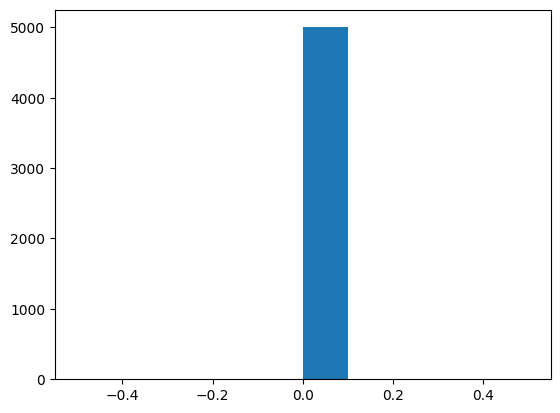

In [ ]:
plt.hist(onp.array(x_out)[0,:,5])

In [ ]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

nan nan [[[1.0000026  0.99999976 1.         ... 1.0000001  1.0000004         nan]
  [1.0000008  0.9999968  1.0000012  ... 1.0000032  0.99999803        nan]
  [0.99999595 1.0000004  1.0000004  ... 1.0000482  1.0000001         nan]
  ...
  [1.         1.         1.         ...        nan        nan        nan]
  [1.         1.         1.         ...        nan        nan        nan]
  [0.9999998  1.0000023  0.99999994 ... 0.99998933 0.99999976        nan]]

 [[1.0000012  1.0000014  0.99999976 ... 1.0000002  1.0000005         nan]
  [0.99999946 0.99999964 1.0000012  ... 0.9999989  0.99999994        nan]
  [0.99999076 0.9999963  1.0000033  ... 1.0000061  0.9999992         nan]
  ...
  [1.0000005  1.0000011  1.0000006  ... 0.99999344 1.0000001         nan]
  [1.0000013  1.0000052  1.0000004  ... 0.9999984  1.000001          nan]
  [1.0000001  0.99999934 1.0000015  ... 0.99999803 0.9999999         nan]]

 [[1.0000178  1.0000005  1.000004   ... 0.9999988  1.0000004         nan]
  [1.         

In [3]:
key = random.PRNGKey(42)
pos = random.uniform(key, shape=(5000,3))
vel = random.uniform(key, shape=(5000,3))
mass = random.uniform(key, shape=(5000,1))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pos.shape

(5000, 3)

In [5]:
sources, targets = nearest_neighbors(pos, 20)

In [6]:
pos = e3nn.IrrepsArray("1o", pos)
feat = e3nn.IrrepsArray(
    f"1o + 0e", 
    np.concatenate([vel, mass], -1)
)


In [7]:
model = NEQUIP()
rng = jax.random.PRNGKey(42)
out, _ = model.init_with_output(rng, pos, feat, targets, sources)


(5000, 7)
1x0e+2x1o
[[ 4.56897148e+04  2.80651360e+07  4.19894080e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.08763867e+03 -7.00658400e+07 -3.39431584e+08 ... -1.75893104e+08
  -3.69769408e+08  4.18078075e+06]
 [ 6.79649609e+03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.58483281e+04  8.81405200e+06  3.07716925e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.12142705e+04 -2.18803828e+05 -1.45930475e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.96228809e+04 -1.60622140e+07 -1.32592880e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


IndexError: Error in IrrepsArray.__getitem__, Can't slice with 1x1o because it doesn't appear exactly once in 1x0e+2x1o.

In [ ]:
out.shape

(5000, 7)

In [9]:
out

1x0e+2x1o
[[ 4.56897148e+04  2.80651360e+07  4.19894080e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.08763867e+03 -7.00658400e+07 -3.39431584e+08 ... -1.75893104e+08
  -3.69769408e+08  4.18078075e+06]
 [ 6.79649609e+03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 2.58483281e+04  8.81405200e+06  3.07716925e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.12142705e+04 -2.18803828e+05 -1.45930475e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.96228809e+04 -1.60622140e+07 -1.32592880e+07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]